<a href="https://colab.research.google.com/github/HARINI-RadheyKrishna/Machine_Learning/blob/master/EE599_ML_Systems_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

## Prerequisites:

* Set the runtime type to GPU. (Runtime -> Change Runtime Type)

# Initial Setup

This section imports all required packages from PyTorch.



In [1]:
#%matplotlib inline
import scipy.ndimage as ndi
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
grays=plt.get_cmap('gray')
np.set_printoptions(precision=2)


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy


import inspect
import re
import pprint

## Mount Google Drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import sys, os
figures_dir = '/content/drive/MyDrive/UtilFolder/hw2_figures'
weights_dir = '/content/drive/MyDrive/UtilFolder/weights'
data_dir = '/content/drive/MyDrive/UtilFolder/data'

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Section 1: Convolution

**Definition**:
Convolution is a mathematical operation where a filter (or kernel) is applied over an input (e.g., image) to produce a modified output known as a feature map.

**Key Components**:
- **Kernel/Filter**: A small matrix that slides over the input. It captures patterns or features from the input.
  
- **Stride**: The number of pixels the filter moves at each step.
  
- **Padding**: Zeros added around the input's border, often used to control the output's spatial dimensions.

**Operation**:
The filter starts at the top-left corner of the image. For each position, values under the filter are multiplied with its corresponding filter values, then summed to produce a single pixel in the output. This process is repeated across the entire input.





## Create a sample image

Create a 2D  `image` of shape `(10,10)` as a numpy-array. The signal values are 1 (white) in the `(4,4)`-center region and 0 (black) elsewhere.

**TODO**: Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

In [6]:
    image = np.zeros((10,10))

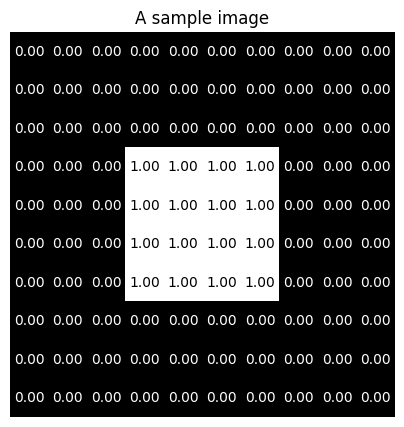

In [7]:
def plot_image_with_values(image, title):
    """
    Plots a 2D image with numeric values overlaid on each cell.

    Parameters:
    - image (2D numpy array): The image to be plotted.
    - title (str): The title of the plot.
    """
    image [3:7, 3:7] = 1

    plt.figure(figsize=(5,5))

    # Plot the image
    plt.imshow(image, cmap='gray')
    #plt.imshow(image, cmap='binary', interpolation='nearest')
    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j] #the value will either be '1' or '0'
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color) #prints the numericals in the middle of each box

    plt.title(title)
    plt.axis('off')
    plt.show()


plot_image_with_values(image, 'A sample image')


## Create an Average Filter

**TODO**: Create a 2-dimensional average filter of size 3x3.

To create a 2-dimensional average filter (also known as a mean filter) of size 3x3, the filter should consist of equal values such that they sum up to 1. For a 3x3 filter, each value in the filter should be $\frac{1}{9}$
  since there are 9 values in total.

- Use `conv2d` to colvolve this filter with `image`. Note that to do so, you have to convert the image from a numpy array to a tensor of appropriate size.
- Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.
- Explain the output.

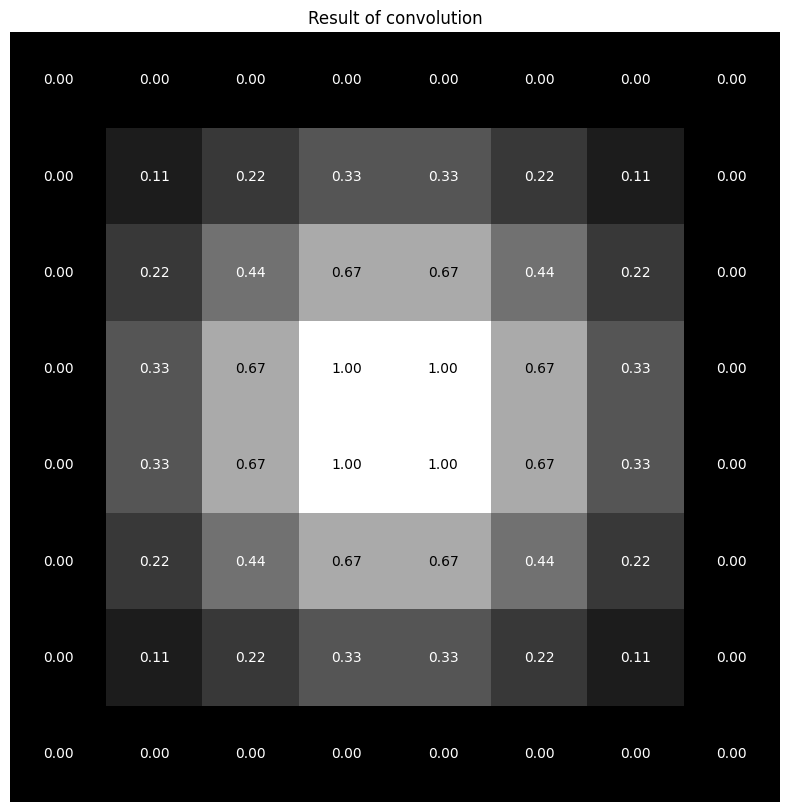

In [15]:
filter_size = 3
filter_value = 1 / (filter_size * filter_size)
filter = np.full((filter_size, filter_size), filter_value)

#Converting the numpy arrays into tensors to apply the conv2d function
filter_tensor = torch.tensor(filter)
image_tensor = torch.tensor(image)

#Applying the convolution function
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
filter_tensor = filter_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
convolved_result = F.conv2d(image_tensor, filter_tensor)
#print(convolved_result, convolved_result.shape)

convolved_result = convolved_result.squeeze().numpy()

plt.figure(figsize = (10,10))
plt.imshow(convolved_result, cmap='gray')
for i in range(convolved_result.shape[0]):
    for j in range(convolved_result.shape[1]):
        pixel_value1 = convolved_result[i, j]
        text_color = 'white' if pixel_value1 < 0.5 else 'black'
        plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
plt.title("Result of convolution")
plt.axis('off')
plt.show()

Output explanation:

    The output is the obtained after the image is convolved with the filter.
    The color intensity of the result image is dependent upon the pixel value of each element in the matrix.
    A 1.00 represents a white background and a black text whereas a 0.00 represents a black background with a white text.
    The value obtained as the result of convolution is by performing a multiplication of the image over the filter value.

## Edge Detection

In image processing, edge detection refers to the process of identifying abrupt changes or discontinuities in an image. These abrupt changes often correspond to object boundaries, textures, or other significant features.

The concept of **central differences** can be applied to images to detect edges by estimating the gradient magnitude at each pixel. In the context of images, the derivative approximations can highlight the areas of rapid intensity change, which are often the edges.


Create a 3x2 2-dimensional filter, which calculates the gradient in x-direction (detecting vertical edges).

Use of the concept of central differences. One possible filter for this purpose is:

\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}


**Question** Why is convolving the image with this filter analogous to computing the partial derivatives of the image with respect to x?

**TODO**: Create this filter and visualize it. Plot the filter as a grid with black or white colors and write the value of each cell on it.


Answer:

When you convolve this filter with an image, you're essentially sliding it over the image pixel by pixel and performing a mathematical operation at each step. This operation involves multiplying the filter's values with the corresponding pixel values in the image and summing up the results.

The central column (0, 0, 0) doesn't contribute to the result, while the left column (-1, -1, -1) and the right column (1, 1, 1) are used to calculate the difference between the pixel values on the left and right sides of the current pixel. This difference represents the rate of change of pixel values in the x-direction, which is essentially the partial derivative with respect to x.

So, convolving the image with this filter effectively computes the gradient in the x-direction, which highlights areas of rapid intensity change, and these are often the edges in the image.



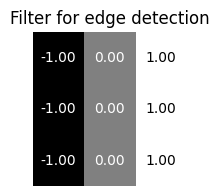

In [10]:
edge_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

#print(edge_filter)

#Visualization of the edge_filter
plt.figure(figsize = (2,2))
plt.imshow(edge_filter, cmap='gray')
for i in range(edge_filter.shape[0]):
    for j in range(edge_filter.shape[1]):
        pixel_value2 = edge_filter[i, j]
        text_color = 'white' if pixel_value2 < 0.5 else 'black'
        plt.text(j, i, f'{pixel_value2:.2f}', ha='center', va='center', color=text_color)
plt.title("Filter for edge detection")
plt.axis('off')
plt.show()

**TODO:** Apply this filter on the original image.

Plot the image as a grid with black or white colors and write value of each cell on it.

<ipython-input-14-e80d75ebaaf5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_filter_tensor = torch.tensor(edge_filter)


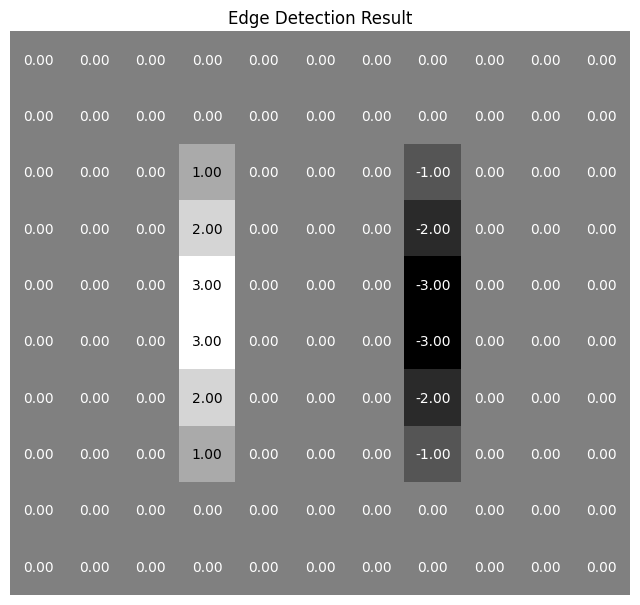

In [14]:
# Define the edge detection filter
edge_filter = torch.tensor([[-1, 1], [-1, 1], [-1, 1]], dtype=torch.float32)

# Initialize the image as a 10x10 numpy array filled with zeros
image = np.zeros((10, 10))
image [3:7, 3:7] = 1
image_tensor = torch.tensor(image, dtype=torch.float32)
edge_filter_tensor = torch.tensor(edge_filter)

# Add batch and channel dimensions
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
edge_filter_tensor = edge_filter_tensor.unsqueeze(0).unsqueeze(0)

# Apply convolution with padding
convolved_result2 = F.conv2d(image_tensor, edge_filter_tensor, padding=1)
convolved_result2 = convolved_result2.squeeze().numpy()


# Plot the image with values
def plot_image_with_values(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value1 = image[i, j]
            text_color = 'white' if pixel_value1 < 0.5 else 'black'
            plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the convolved result
plot_image_with_values(convolved_result2, 'Edge Detection Result')

### Horizontal Edge
TODO:
Create a similar filter to detect horizontal edges.

<ipython-input-21-90b984612666>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hedge_filter_tensor = torch.tensor(hedge_filter)


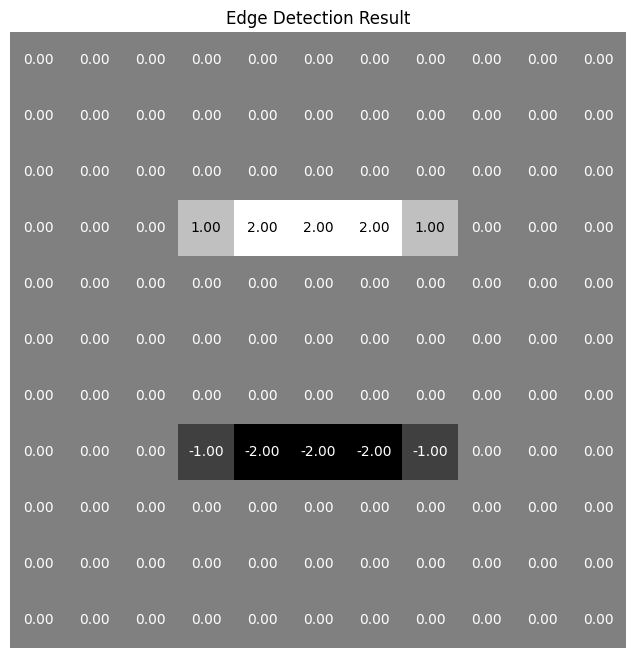

In [21]:
# Define the edge detection filter
hedge_filter = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float32)

# Initialize the image as a 10x10 numpy array filled with zeros
image = np.zeros((10, 10))
image [3:7, 3:7] = 1
image_tensor = torch.tensor(image, dtype=torch.float32)
hedge_filter_tensor = torch.tensor(hedge_filter)

# Add batch and channel dimensions
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
hedge_filter_tensor = hedge_filter_tensor.unsqueeze(0).unsqueeze(0)

# Apply convolution with padding
convolved_result3 = F.conv2d(image_tensor, hedge_filter_tensor, padding=1)
convolved_result3 = convolved_result3.squeeze().numpy()


# Plot the image with values
def plot_image_with_values(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value1 = image[i, j]
            text_color = 'white' if pixel_value1 < 0.5 else 'black'
            plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the convolved result
plot_image_with_values(convolved_result3, 'Edge Detection Result')

### Laplacian Sharpening
Lapalacian filters can increase the regions of the image with rapid intensity. It is very helpful in hding the fine details of images. Any features with a sharp discontunioty will be enhanced.

One of the Laplacian filter is

\begin{bmatrix}
 0 & -1 &  0 \\
-1 &  4 & -1 \\
 0 & -1 &  0 \\
\end{bmatrix}

To sharpen an image ```img```:

1. use the Laplacian filter to convolve the original image to obtained a filter.
2. scale the filter into the range of the oringal image.
3. add the filter to the original image.
4. scale the summation to the range of the original image.


TODO: Create this filter and visualize it. Plot the filter as a grid with black or white colors and write the value of each cell on it.

<ipython-input-23-d0b2a3649086>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_laplacian_tensor = torch.tensor(filter_laplacian)


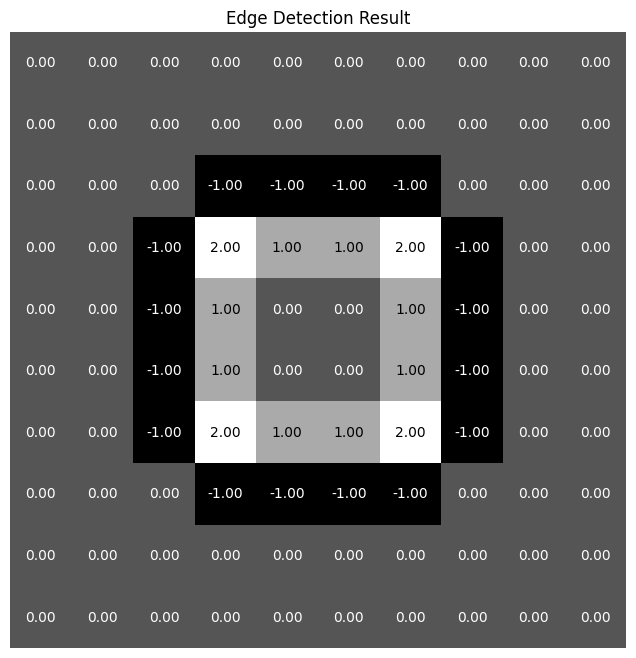

In [23]:
filter_laplacian = torch.tensor ([[0,-1, 0], [-1, 4, -1], [0, -1, 0]], dtype = torch.float32)

TODO: Apply this filter on the original image.

Plot the image as a grid with black or white colors and write value of each cell on it.

<ipython-input-24-8c3589ebb1a5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filter_laplacian_tensor = torch.tensor(filter_laplacian)


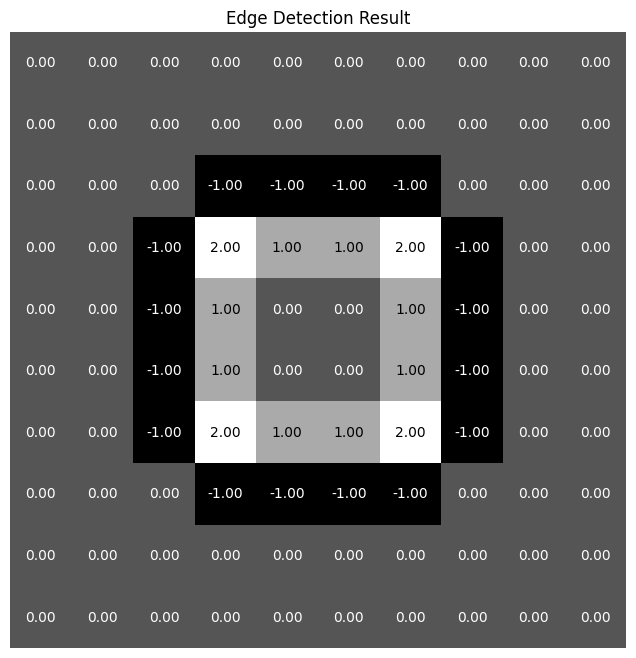

In [24]:
# Initialize the image as a 10x10 numpy array filled with zeros
image = np.zeros((10, 10))
image [3:7, 3:7] = 1
image_tensor = torch.tensor(image, dtype=torch.float32)
filter_laplacian_tensor = torch.tensor(filter_laplacian)

# Add batch and channel dimensions
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
filter_laplacian_tensor = filter_laplacian_tensor.unsqueeze(0).unsqueeze(0)

# Apply convolution with padding
Laplacian_result = F.conv2d(image_tensor, filter_laplacian_tensor, padding=1)
Laplacian_result = Laplacian_result.squeeze().numpy()

# Plot the image with values
def plot_image_with_values(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value1 = image[i, j]
            text_color = 'white' if pixel_value1 < 0.5 else 'black'
            plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the convolved result
plot_image_with_values(Laplacian_result, 'Edge Detection Result')

## Applying Filters on an Image

In this section we apply several filters on a real image.

**TODO**
Use `PIL` library to read the attached image called `cars-1638594_1280.jpg` as a numpy array. Convert that image to grayscale so that it only has a single channel and plot the image.

In [37]:
from PIL import Image

# Specify the file path
file_path = 'data_dir/cars-1638594_1280.jpg'

# Check if the file exists
if os.path.isfile(file_path):
    print(f'The file at {file_path} exists.')
else:
    print(f'The file at {file_path} does not exist.')


The file at data_dir/cars-1638594_1280.jpg does not exist.


In [40]:
from PIL import Image

image_path = os.path.join(figures_dir, 'cars-1638594_1280.jpg')
image = Image.open(image_path)

#Applying the graycscale to the image
gray_image = image.convert('L')

image_np = np.array(image) #converting the image from a PIL format to a numpy array format

plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.title('Grayscale image')
plt.show()

FileNotFoundError: ignored

**TODO**:
Apply the vertical edge detection to the image and plot both original and converted image.

In [41]:
filter_laplacian = torch.tensor([])
image_original_tensor = torch.tensor(image, dtype=torch.float32)
image_tensor = torch.tensor(image_np, dtype=torch.float32)
filter_laplacian_tensor = torch.tensor(filter_laplacian)

# Add batch and channel dimensions
image_tensor = image_original_tensor.unsqueeze(0).unsqueeze(0)
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
filter_laplacian_tensor = filter_laplacian_tensor.unsqueeze(0).unsqueeze(0)

# Apply convolution with padding
#original image
Laplacian_result_original = F.conv2d(image_original_tensor, filter_laplacian_tensor, padding=1)
Laplacian_result_original = Laplacian_result_original.squeeze().numpy()

#Grayscale image
Laplacian_result = F.conv2d(image_tensor, filter_laplacian_tensor, padding=1)
Laplacian_result = Laplacian_result.squeeze().numpy()

# Plot the image with values
def plot_image_with_values(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value1 = image[i, j]
            text_color = 'white' if pixel_value1 < 0.5 else 'black'
            plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the convolved result
plot_image_with_values(Laplacian_result, 'Vertical Edge Detection Result for Converted Image')
plot_image_with_values(Laplacian_result_original, 'Vertical Edge Detection Result for Original Image')

NameError: ignored

**TODO**:
Apply the horizontal edge detection to the image and plot both original and converted image.




In [ ]:
filter_laplacian = torch.tensor([])
image_original_tensor = torch.tensor(image, dtype=torch.float32)
image_tensor = torch.tensor(image_np, dtype=torch.float32)
filter_laplacian_tensor = torch.tensor(filter_laplacian)

# Add batch and channel dimensions
image_tensor = image_original_tensor.unsqueeze(0).unsqueeze(0)
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
filter_laplacian_tensor = filter_laplacian_tensor.unsqueeze(0).unsqueeze(0)

# Apply convolution with padding
#original image
Laplacian_result_original = F.conv2d(image_original_tensor, filter_laplacian_tensor, padding=1)
Laplacian_result_original = Laplacian_result_original.squeeze().numpy()

#Grayscale image
Laplacian_result = F.conv2d(image_tensor, filter_laplacian_tensor, padding=1)
Laplacian_result = Laplacian_result.squeeze().numpy()

# Plot the image with values
def plot_image_with_values(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value1 = image[i, j]
            text_color = 'white' if pixel_value1 < 0.5 else 'black'
            plt.text(j, i, f'{pixel_value1:.2f}', ha='center', va='center', color=text_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the convolved result
plot_image_with_values(Laplacian_result, 'Vertical Edge Detection Result for Converted Image')
plot_image_with_values(Laplacian_result_original, 'Vertical Edge Detection Result for Original Image')

**TODO**:
Apply the sharpening to the image and plot both original and converted image.




### Bluring the image with the Gaussian filter

One commonly used filter for blurring is the Gaussian filter. Its values are determined by the Gaussian function, which results in a bell-shaped curve.

A Gaussian filter tends to give more weight to the central pixels and gradually decreasing weight as one moves to the periphery, unlike the uniform averaging filter we discussed earlier.

**TODO**:
Create a 5x5 Gaussian blur filter with these values:

\begin{bmatrix}
1 & 4 & 6 & 4 & 1 \\
4 & 16 & 24 & 16 & 4 \\
6 & 24 & 36 & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 & 4 & 6 & 4 & 1 \\
\end{bmatrix}

Apply the filter to the image and plot both original and converted image.


## Pooling

Pooling is an operation frequently used in the context of Convolutional Neural Networks (CNNs) for image processing. The main idea behind pooling is to reduce the spatial size of the representation, thereby reducing the number of parameters and computational complexity in the network. This helps in making the network less prone to overfitting and also reduces computation time.

There are several types of pooling operations, with the most common ones being:

**Max Pooling**: In this method, for each segment of the input, the maximum value is selected. For instance, if we consider a 2x2 pooling window (often called a "kernel" in this context) and slide it over an image tensor, the largest value within each 2x2 window will be selected for the pooled output.

- **Average Pooling**: Instead of taking the maximum value in each window, average pooling takes the average value. So for a 2x2 window, it would take the average of all 4 values in that window.
- **Min Pooling**: This operation selects the minimum value from each window, though it's less commonly used than max or average pooling.
- **Global Pooling**: Instead of using a fixed size window, global pooling operates over the entire height and width of the feature map, effectively transforming the spatial dimensions of the feature map to 1x1 (retaining the depth/channels).

The main benefits of pooling include:

- **Dimensionality Reduction**: It reduces the spatial dimensions of the feature maps, which in turn reduces the number of parameters in subsequent layers, leading to faster computations.
- **Invariance to Small Translations**: Small translations in the input image might not lead to significant changes in the pooled feature map. This can be particularly useful when the exact location of features is less relevant than their presence.
- **Prevents Overfitting**: By reducing the spatial resolution and thus the total number of parameters, pooling can help prevent overfitting.


### Max Pooling:
Create a Max Pooling filter of size 8 with stride 2 and run it on the original image.

**TODO:** Explain the output and its shape dimensions.

### Average Pooling:
Create an average pooling filter of size 8 with stride 2 and run it on the original image.

**TODO:** Explain the output and its shape dimensions.

# Section 2: Convolutional Neural Networks

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

TODO: Complete the next code block.

In [ ]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline

# Load the CIFAR10 training dataset and apply the defined transformations


# Create a DataLoader to efficiently load and process training data in batches


# Load the CIFAR10 test dataset and apply the same transformations as for training


# Create a DataLoader for test data

# classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's view some of the images.

In [ ]:

# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()


    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

TODO: Define a simple CNN that classifies CIFAR images.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5,no bias
        self.conv1 =

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool =

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5, no bias
        self.conv2 =

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features, no bias
        self.fc1 =

        # Second fully connected layer: 120 input features, 84 output features, no bias
        self.fc2 =

        # Third fully connected layer: 84 input features, 10 output features (for classification), no bias
        self.fc3 =

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling

        # Apply second convolutional layer, followed by ReLU activation and max pooling

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].

        # Apply first fully connected layer, followed by ReLU activation

        # Apply second fully connected layer, followed by ReLU activation

        # Apply third fully connected layer (output layer)

        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [ ]:
def train(model: nn.Module, dataloader: DataLoader):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(2):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete
    PATH = os.path.join(weights_dir, 'cifar_net.pth')
    torch.save(net.state_dict(), PATH)



In [ ]:
train(net, trainloader)

Now that the CNN has been trained, let's test it on our test dataset.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


# net = Net()
# net.load_state_dict(torch.load(PATH))
net.cuda()
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Let us look at how the network performs on the whole dataset.


In [ ]:

# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

## Question 1: Visualize Weights

Write a function that takes one layer of our network and plots the historgram of its paramters. Use this signature:

```python
def analyze_layer_weights(layer: nn.Module):
```

In [ ]:
def analyze_layer_weights(layer: nn.Module):
    # Extract and flatten the weights of the given layer
    layer_weights = layer.weight.data.cpu().view(-1)

    # Get layer type (Conv2d or Linear) for better title
    layer_type = type(layer).__name__

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_type} Layer Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.show()

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (layer_weights.mean() + 3 * layer_weights.std()).item()
    layer_weights_3sigma_min = (layer_weights.mean() - 3 * layer_weights.std()).item()

    # Calculate the range of weights and the 3-sigma range for the layer
    weight_range = layer_weights.max() - layer_weights.min()
    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min

    print(f"{layer_type} Layer Weight Range: {weight_range.item()}")
    print(f"{layer_type} Layer 3-Sigma Range: {sigma_range}")

In [ ]:
analyze_layer_weights(net.conv1)

In [ ]:
analyze_layer_weights(net.conv2)

In [ ]:
analyze_layer_weights(net.fc1)

In [ ]:
analyze_layer_weights(net.fc2)

In [ ]:
analyze_layer_weights(net.fc3)

## Question 2: Model Dimensions.
TODO:
In the CNN model we have created, how many layers have trainable weights? Please list all the dimensions of each layer's weights.


TODO: For all the layers with traiable weights, please list their input and output dimension.

TODO: For all the layers, please list their total number of multiplications and summations in both forward and backward pass.

TODO: Calculate the maximum memory requirements to run the training for this CNN model. Hint: Weights + gradients + maximum intermediate feature.

## Question 3: Model without MaxPooling2D
TODO: remove the MaxPooling2D layer in the CNN model we have created and adjust the dimension of FC layers to have a matching layer.

TODO: Evaluate the model accuracy and compare it with the CNN model with MaxPooling.

TODO: repeat question 2 for the CNN model without MaxPooling2D.